In [1]:
import torch
from torch import nn
import circuits as ckt
import learn as lrn

In [2]:
# Get cpu or gpu device for training.
# device = "cuda" if torch.cuda.is_available() else "cpu"
device = "cpu"
print(f"Using {device} device")

# torch.autograd.set_detect_anomaly(True)

Using cpu device


# Generate Input Data for a Simple Circuit
Circuit is an independent voltage source and a resistor.

Circuit with 2 nodes and 2 elements
[0, 1]
[(1 , 0), (1 , 0)]
[(1, {}), (0, {})]
[(1, 0, 0, {'kind': <Kinds.IVS: 0>, 'i': -1000000.0, 'v': None, 'attr': 1}), (1, 0, 1, {'kind': <Kinds.R: 2>, 'i': None, 'v': None, 'attr': None})]


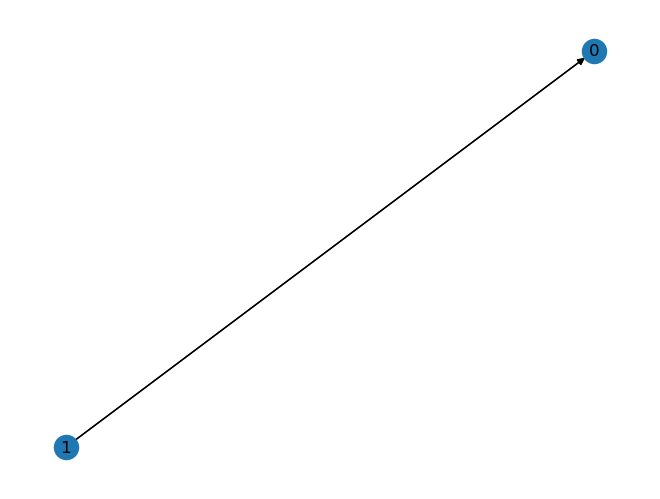

In [3]:
vr = ckt.Circuit()

v_source = vr.add_element(kind=ckt.Kinds.IVS)
r1 = vr.add_element(kind=ckt.Kinds.R)
v_source.connect(v_source.high, r1.high)
v_source.connect(v_source.low, r1.low)
# Case 1 all resistances known
# v_source.attr = 1
# r1.attr = 1e6
# # Case 2 one resisance unknown
v_source.attr = 1
v_source.i = -1e6

# v_source = vr.add_element(kind=ckt.Kinds.IVS)
# r1 = vr.add_element(kind=ckt.Kinds.R)
# r2 = vr.add_element(kind=ckt.Kinds.R)
# v_source.connect(v_source.high, r1.high)
# r1.connect(r1.low, r2.high)
# v_source.connect(v_source.low, r2.low)
# # Case 1 all resistances known
# v_source.attr = 1
# r1.attr = 1e6
# r2.attr = 1e6
# # Case 2 one resisance unknown
# v_source.attr = 1
# r1.attr = 1e6
# r2.v = 0.5

print(vr)
print(vr.nodes)
print(vr.elements)
vr.draw()
print(vr.nx_graph().nodes().data())
print(vr.nx_graph().edges(data=True,keys=True))

# Expected Sizes of Vectors

In [4]:
print(f'size of element currents, voltages, and attr = ({vr.num_elements()},1)')
print(f'size of node voltages = ({vr.num_nodes()},1)')

size of element currents, voltages, and attr = (2,1)
size of node voltages = (2,1)


# Inputs

In [5]:
input_test = ckt.Input(vr)

c:\Users\terry\OneDrive\Documents\GitHub\side_circuit\ml\circuits.py:67: FutureWarning: incidence_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  M_scipy = nx.incidence_matrix(G=self.nx_graph(),oriented=True)


In [6]:
input_test.M

tensor([[-1., -1.],
        [ 1.,  1.]])

In [7]:
input_test.M_red

tensor([[-1., -1.]])

# Circuit Theory Functions

In [8]:
init_params = input_test.init_params()
init_params

(Parameter containing:
 tensor([[-1.0000e+06],
         [ 7.6070e-01]], requires_grad=True),
 Parameter containing:
 tensor([[1.0000],
         [0.6267]], requires_grad=True),
 Parameter containing:
 tensor([[0.4924],
         [0.7707]], requires_grad=True),
 Parameter containing:
 tensor([[1.0000],
         [0.3918]], requires_grad=True))

In [9]:
input_test.X_row(init_params[ckt.Props.Attr.value])

tensor([[ 0.0000,  0.0000,  1.0000,  0.0000,  0.0000],
        [ 0.0000, -0.3918,  0.0000,  1.0000,  0.0000]], grad_fn=<AddBackward0>)

In [10]:
input_test.kinds_map

{<Kinds.IVS: 0>: [True, False],
 <Kinds.ICS: 1>: [False, False],
 <Kinds.R: 2>: [False, True]}

In [11]:
# input_test.s(init_params[ckt.Props.Attr.value])

# Define Models

In [12]:
torch.zeros_like(input_test.M)

tensor([[0., 0.],
        [0., 0.]])

In [13]:
torch.eye(input_test.circuit.num_elements())

tensor([[1., 0.],
        [0., 1.]])

In [14]:
-input_test.M_red.T

tensor([[1.],
        [1.]])

In [15]:
class Solve():
    ''' 
    Sparse Tableau Formulation of circuit analysis, modeled as a machine learning
    problem to learn element attributes using backprop and optimization.
    '''
    def __init__(self, input: ckt.Input, attr:nn.Parameter):
        # super().__init__()
        self.input = input
        self.attr = None
        if(attr != None):
            # assign if used as standalone solver without optimizer
            self.attr = attr.clone().detach().requires_grad_(False)
        

    def solve(self):
        '''
            Returns prediction given the IVS, ICS, and element attributes.  Uses 
            the linear algebra solution to the Sparse Tableau Formulation of the
            circuit.
            Prediction contains element currents, element voltages, and node 
            potentials. Node potentials are missing the reference node since it 
            is removed from the STF to avoid singular matrix A.
            Output is 2D tensor of shape ( 2 * elements + nodes - 1, 1)
        '''
        A,b, i_base, v_base, r_base = self.build()
        return self.denormalize(torch.linalg.solve(A,b),i_base,v_base)
    
    def normalize(self, attr:nn.Parameter):
        # get values
        currents = torch.tensor(self.input.inputs_map[ckt.Props.I])
        voltages = torch.tensor(self.input.inputs_map[ckt.Props.V])
        ics = attr[self.input.kinds_map[ckt.Kinds.ICS]]
        ivs = attr[self.input.kinds_map[ckt.Kinds.IVS]]
        r = attr[self.input.kinds_map[ckt.Kinds.R]]

        max_currents = 1
        max_ics = 1
        if(currents.nelement() > 0):
            max_currents = torch.max(torch.abs(currents)).item()
        if(ics.nelement() > 0):
            max_ics = torch.max(torch.abs(ics)).item()
        max_i = max(max_currents,max_ics)

        max_voltages = 1
        max_ics = 1
        if(voltages.nelement() > 0):
            max_voltages = torch.max(torch.abs(voltages)).item()
        if(ivs.nelement() > 0):
            max_ivs = torch.max(torch.abs(ivs)).item()
        max_v = max(max_voltages,max_ivs)

        max_r = 1
        if(r.nelement() > 0):
            max_r = torch.max(torch.abs(r))
        i_base = max(max_i,max_v/max_r)
        v_base = max(max_v,max_i*max_r)
        r_base = v_base/i_base
        # print(f'bases: i={i_base}, v={v_base},r={r_base}')

        # make norms
        ics_norm = ics/i_base
        ivs_norm = ivs/v_base
        r_norm = r/r_base

        attr_norm = torch.zeros_like(attr)
        attr_norm[self.input.kinds_map[ckt.Kinds.ICS]] = ics_norm
        attr_norm[self.input.kinds_map[ckt.Kinds.IVS]] = ivs_norm
        attr_norm[self.input.kinds_map[ckt.Kinds.R]] = r_norm

        return attr_norm, i_base, v_base, r_base
    
    def denormalize(self, solution, i_base, v_base):
        num_elements = self.input.circuit.num_elements()
        num_nodes = self.input.circuit.num_nodes()
        i_denorm = solution[:num_elements] * i_base
        v_denorm = solution[num_elements:2*num_elements] * v_base
        pot_denorm = solution[2*num_elements:] * v_base

        return torch.cat(tensors=(i_denorm,v_denorm,pot_denorm))

    def build(self):
        # inputs
        attr_norm, i_base, v_base, r_base = self.normalize(self.attr)
        s = self.input.s(attr_norm)
        M = self.input.M
        M_red = self.input.M_red
        num_elements = self.input.circuit.num_elements()
        num_nodes = self.input.circuit.num_nodes()
                
        # A matrix
        kcl_row = torch.cat(tensors=(M_red,
                                    torch.zeros_like(M_red),
                                    torch.zeros_like(M_red[:,:-1])),dim=1)
        kvl_row = torch.cat(tensors=(torch.zeros_like(M),
                                    torch.eye(num_elements),
                                    -M_red.T),dim=1)
        e_row = self.input.X_row(attr_norm)
        A = torch.cat(tensors=(kcl_row,kvl_row,e_row), dim=0)

        # b matrix
        kcl_zeros = torch.zeros(size=(num_nodes - 1,1))
        kvl_zeros = torch.zeros(size=(num_elements,1))
        b = torch.cat(tensors=(kvl_zeros,kcl_zeros,s), dim=0)
        
        return A,b, i_base, v_base, r_base

# Create Solver

In [16]:
import time
input = ckt.Input(vr)
start_time = time.time()
_,_,_,attr_param = input.init_params()
model = Solve(input=input,attr=attr_param)
solution = model.solve()
end_time = time.time()
print(solution)

tensor([[-11.9767],
        [ 11.9767],
        [  1.0000],
        [  1.0000],
        [ -1.0000]])


In [17]:
input.output_vector(input.knowns_map,True)

tensor([[ True],
        [False],
        [ True],
        [False],
        [False]])

In [18]:
input.output_vector(input.inputs_map,False)

tensor([[-1.0000e+06],
        [ 3.3790e-01],
        [ 1.0000e+00],
        [ 6.1006e-01],
        [ 0.0000e+00]])

In [19]:
print(f'execution time = {(end_time - start_time)*1000} ms')

execution time = 2.006053924560547 ms


In [20]:
solution

tensor([[-11.9767],
        [ 11.9767],
        [  1.0000],
        [  1.0000],
        [ -1.0000]])

# Optimizing Resistance

In [21]:
class Element_Optimizer(nn.Module, Solve):
    def __init__(self, input: ckt.Input, attr:nn.Parameter) -> None:
        nn.Module.__init__(self)
        Solve.__init__(self,input=input,attr=attr)
        self.attr = attr

    def forward(self):
        return self.solve()
    
    def get_params(self):
        return self.attr
    
    def zero_known_grads(self):
        if(self.attr != None and self.attr.grad != None):
            self.attr.grad[self.input.knowns_map[ckt.Props.Attr]] = 0

In [22]:
num_epochs = 10000
prev_loss = 0.1

model = Element_Optimizer(input=input, attr=attr_param)
optimizer = torch.optim.Adam(params=model.parameters(),lr=0.000001)
selection = input.output_vector(input.knowns_map,True)
truths = input.output_vector(input.inputs_map,False)
loss, _ = lrn.train(model,optimizer,nn.MSELoss(),truths,selection)
print(f'init params: {attr_param}')
print(f'init loss: {loss.item()}')

epoch = 0

while(epoch < num_epochs):

    loss, _ = lrn.train(model,optimizer,nn.MSELoss(),truths,selection)
    if(loss < 1e-6):
            break

    epoch += 1
    loss_change = abs(loss - prev_loss) / prev_loss
    prev_loss = loss

print(f'Done! at {epoch} passes')
print(f'solution = {model()}')
print(f"attributes = {attr_param}")

init params: Parameter containing:
tensor([[1.0000],
        [0.0835]], requires_grad=True)
init loss: 499988004864.0
Done! at 10000 passes
solution = tensor([[-13.6473],
        [ 13.6473],
        [  1.0000],
        [  1.0000],
        [ -1.0000]], grad_fn=<CatBackward0>)
attributes = Parameter containing:
tensor([[1.0000],
        [0.0733]], requires_grad=True)
